In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from collections import namedtuple
# from bokeh.plotting import figure, show, row, output_notebook
# from bokeh.plotting import output_notebook
# output_notebook()
import tqdm.notebook as tqdm
# import seaborn as sns
from matplotlib.colors import ListedColormap


# Defining models
Before starting to simulate things we need to define the models we are gonna use. We create pytorch modules to do that. 
In this regard the module wants:
- an init function where the module is initialized (super(LIF)) and parameters are defined
- a reset function mainly used for cleaning the variables before re-running, also useful for erasing the backward graph when doing backprop.
- a forward function used to compute at every iteration the state of the variables. Note that to store the state of the variables up to the next time step we use namedtuple.
- a backward function used to calculate the backward error, here not implemented because in this example we are not doing backprop.

## LIF model
The neuron is a CUBA LIF neuron. In these neurons both synapses and neurons are integrating their input over time. 
### Synapse
The synapse as $$\frac{dI}{dt} = -\frac{I}{\tau_{syn}} + \frac{\sum_j{gain_{syn}\cdot spk_{in}^j}}{C_{syn}} $$
where $C_{syn}$ in this case is set to 1, $gain_{syn}$ is a voltage to current conversion and $spk_{in}^j$ represent the input spikes from the j-th neuron.
In the case of the sPLL the LIF model has only one input synapse (coming from the TDE), so to speed up the computation we substituted the matmul with a simple multiplication.
### Soma
The current created by the synapse gets then fed into the neuron. The neuron, similarly to the synapse, integrates the input as:
$$\frac{dV}{dt} = -\frac{V}{\tau_{neu}} + \frac{I + I_{steady}}{C_{syn}} $$
At this point the spike comes in action:
$$ if\ V > V_{thr} \rightarrow spk = 1 $$
Then we have a refractory period that prevent the neuron for spiking for a given time:
$$ if\ spk \rightarrow count_{refr} = T_{refr}\\ else\ count_{refr} = count_{refr} - 1 $$
Then we save the V,I and $count_{refr}$ for the next iteration
### Neuron as Current Controlled Oscillator
We use this neuron as a current controlled oscillator, meaning that we set it to a specific frequency using stable_current and then with I we excite it so it spikes faster.
Stable current is initialized as 
$$ I_{stable} = I_{minimum} + I_{step}*i $$
where i is the index of the neuron. In this way we instantiate the entire layer and every neuron has a different stable current than the other, effectively making them spiking at different frequencies

In [24]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 20.0  # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return (input > 0.).float()

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2
        return grad


activation = SurrGradSpike.apply


In [25]:
class LIF_neuron(nn.Module):
    NeuronState = namedtuple('NeuronState', ['V', 'I','count_refr'])

    def __init__(self, parameters):
        super(LIF_neuron, self).__init__()
        self.C = parameters['C_Osc']
        self.thr = parameters['v_Osc_threshold']
        self.state = None
        self.bs = parameters['trials_per_stimulus']
        self.n = parameters['neurons_n']
        self.tau_syn = parameters['tau_Osc_Ie']
        self.tau_neu = parameters['tau_Osc']
        self.gain_syn = parameters['TDE_to_Osc_current']
        self.dt = parameters['clock_sim']
        self.Vr = parameters['reset_osc']
        self.device = parameters['device']
        self.I_minimum_osc = parameters['I_minimum_osc']
        self.I_step_osc = parameters['I_step_osc']
        self.refrac_Osc = parameters['refrac_Osc']
        self.steady_current = torch.tensor([self.I_minimum_osc + self.I_step_osc * i for i in range(self.n)]).to(self.device)
        self.refr = self.refrac_Osc/self.dt

    def initialize_state(self,parameters):
        self.state = None
        self.bs = parameters['trials_per_stimulus']
    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=torch.ones((self.bs,self.n), device=input.device),
                                          I=torch.zeros((self.bs,self.n), device=input.device),
                                          count_refr = torch.zeros((self.bs,self.n), device=input.device)
                                          )
        V = self.state.V
        I = self.state.I
        count_refr = self.state.count_refr
        I += -self.dt * I / self.tau_syn + self.gain_syn * input
        V += self.dt * (-V / self.tau_neu + (I + self.steady_current) / self.C)
        spk = ((V - self.thr) > 0.).float()
        count_refr = self.refr*(spk) + (1-spk)*(count_refr-1)
        V = (1 - spk) * V * (count_refr <= 0) + spk * self.Vr
        self.state = self.NeuronState(V=V, I=I,count_refr = count_refr)
        return spk

## TDE model
The TDE model is similar to the LIF neuron explained above. The only difference is that it has 2 different synapses: the facilitatory and the trigger.
### Facilitatory and Trigger synapses
The facilitatory synapse behaves as a normal synapse:
$$\frac{dI_{fac}}{dt} = -\frac{I_{fac}}{\tau_{fac}} + \frac{gain_{fac}\cdot spk_{fac}}{C_{fac}} $$
The trigger synapse instead uses the current value of the facilitatory synapse to compute its gain:
$$\frac{dI_{trg}}{dt} = -\frac{I_{trg}}{\tau_{trg}} + \frac{gain_{trg}\cdot I_{fac}\cdot spk_{in}}{C_{trg}} $$
### Soma
Then the current of the $I_{trg}$ gets fed into the soma as in the LIF

### The TDE as a Phase Detector

We use the fact that the spike rate of the neuron depends on the time difference between the facilitatory spike and the trigger spike to compute the phase difference between the spike train of the input and of the CCO

In [26]:
class TDE(nn.Module):
    NeuronState = namedtuple('NeuronState', ['v', 'i_trg', 'i_fac','count_refr'])

    def __init__(self, parameters):
        super(TDE, self).__init__()
        self.C = parameters['C_TDE']
        self.thr = parameters['v_TDE_threshold']
        self.state = None
        self.bs = parameters['trials_per_stimulus']
        self.n = parameters['neurons_n']
        self.tau_trg = parameters['tau_trg_TDE']
        self.tau_fac = parameters['tau_fac_TDE']
        self.gain_fac = parameters['gain_fac_TDE']
        self.gain_trg = parameters['gain_trg_TDE']
        self.beta = parameters['tau_TDE']
        self.dt = parameters['clock_sim']
        self.Vr = parameters['reset_TDE']
        self.refr = parameters['refrac_TDE']/self.dt
        self.device = parameters['device']
        # self.refr.to(self.device)

    def initialize_state(self,parameters):
        self.state = None
        self.bs = parameters['trials_per_stimulus']
    def forward(self, input_trg, input_fac):
        if self.state is None:
            self.state = self.NeuronState(v=torch.zeros(input_trg.shape, device=input_trg.device),
                                          i_trg=torch.zeros(input_trg.shape, device=input_trg.device),
                                          i_fac=torch.zeros(input_trg.shape, device=input_trg.device),
                                          count_refr = torch.zeros((self.bs,self.n), device=input_trg.device)
                                          )

        assert input_trg.shape == input_fac.shape, "TRG and FAC should have same dimensions, while: shape trg: " + str(input_trg.shape) + ", shape fac: " + str(input_fac.shape)
        v = self.state.v
        i_trg = self.state.i_trg
        i_fac = self.state.i_fac
        count_refr = self.state.count_refr
        i_fac += -self.dt / self.tau_fac * i_fac + self.gain_fac * input_fac
        i_trg += -self.dt / self.tau_trg * i_trg + self.gain_trg * input_trg * i_fac
        v += self.dt * (- v / self.beta + i_trg / self.C)
        spk = ((v - self.thr)>0.).float()
        count_refr = self.refr*(spk) + (1-spk)*(count_refr-1)
        v = (1 - spk) * v * (count_refr <= 0) + spk * self.Vr
        self.state = self.NeuronState(v=v, i_trg=i_trg, i_fac=i_fac,count_refr= count_refr)
        return spk

## SPLL model
Here we arrive to the main character of the story. We create here, using a LIF and a TDE, a spiking phase locked loop.
As we can see we first initialize the TDE and the LIF neurons, then we initialize the currents meant to be fed to the LIFs. 
The forward path is simply feeding the spikes of the TDE of the previous time step to the LIF, then feeding the LIF output to the TDE and then moving to the next time step

In [27]:
class sPLL(nn.Module):
    def __init__(self, parameters):
        super(sPLL, self).__init__()
        self.device = parameters['device']
        self.TDE = TDE(parameters).to(self.device)
        self.LIF = LIF_neuron(parameters).to(self.device)
        self.n_out = parameters['neurons_n']
        self.n_in = 1
        self.tmp_current_list = nn.Parameter(torch.linspace(parameters['I_minimum_osc'],parameters['I_minimum_osc'] + parameters['I_step_osc']*self.n_out,self.n_out),requires_grad=False).to(self.device)
    def initialize_state(self,parameters):
        self.LIF.initialize_state(parameters)
        self.TDE.initialize_state(parameters)
        self.bs = parameters['trials_per_stimulus']
        self.input_fac = torch.zeros((self.bs,self.n_out), device=self.device)
        self.spikes_TDE_prev = torch.zeros((self.bs,self.n_out), device=self.device).to_sparse()
        self.spikes_TDE = torch.zeros((self.bs,self.n_out), device=self.device).to_sparse()
        self.spikes_LIF = torch.zeros((self.bs,self.n_out), device=self.device).to_sparse()
        self.current_list = self.tmp_current_list*(torch.ones_like(self.input_fac).to(self.device))
        self.LIF.steady_current = self.current_list
    def forward(self, input):
        # input_expanded = input*torch.ones([input.shape[0],self.n_out]).to(self.device).T
        self.spikes_LIF = self.LIF(self.spikes_TDE_prev)
        self.spikes_TDE = self.TDE(self.spikes_LIF,input)
        self.spikes_TDE_prev = self.spikes_TDE
        return self.spikes_TDE, self.spikes_LIF

# Defining the parameters
## Defining general parameters

In [28]:
parameters = {}

In [29]:
# parameters['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
parameters['device'] = torch.device("cpu")
print('device in use:',parameters['device'])
parameters['neurons_n'] = 50
parameters['frequencies'] = 1
parameters['clock_sim'] = 0.01e-3
parameters['trials_per_stimulus'] = 1
sim_time = 1

device in use: cpu


## Defining LIF model and simulating it
Here we define the LIF model and we show how the different currents fed as $I_{steady}$

In [30]:
parameters['C_Osc'] = 1
parameters['v_Osc_threshold'] = 1
parameters['tau_Osc_Ie'] = 10e-3
parameters['tau_Osc'] = 100e-3
parameters['TDE_to_Osc_current'] = 5
parameters['reset_osc'] = 0
parameters['I_minimum_osc'] = 12
parameters['I_step_osc'] = 2
parameters['refrac_Osc'] = 1e-3
parameters['trials_per_stimulus'] = 1

Simulating LIF:   0%|          | 0/99999 [00:00<?, ?it/s]

[5.5506216412732385, 7.919537739460617, 10.093872497537218, 12.183235993784285, 14.22272860599217, 16.231133708615623, 18.218253677120575, 20.18571078043036, 22.133689118647208, 24.07317997526637, 26.001041647798868, 27.917361795851825, 29.815143425885058, 31.715825926271627, 33.602149151930064, 35.473569866566166, 37.34130213511454, 39.20031350267316, 41.050904426649744, 42.90004961460979, 44.74272887095786, 46.57662047965847, 48.3792969365658, 50.20080118049807, 52.002083295597735, 53.82131618042236, 55.61735260110936, 57.40527690966022, 59.17159380363026, 60.938449852509386, 62.69592510461468, 64.47453523188642, 66.22516369381519, 67.98096202008479, 69.6864164612673, 71.42857397545366, 73.15288821383712, 74.85030341180563, 76.56967415620646, 78.3085247363836, 79.99999880790712, 81.69935216010167, 83.40283873966496, 85.03400586273843, 86.73027048015132, 88.41731544952735, 90.0900919525841, 91.74312617670266, 93.37068107854284, 94.96676504959403]


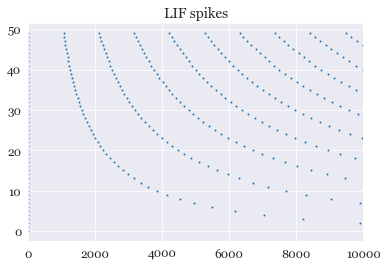

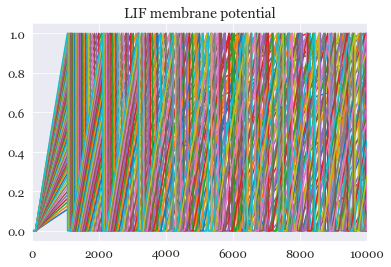

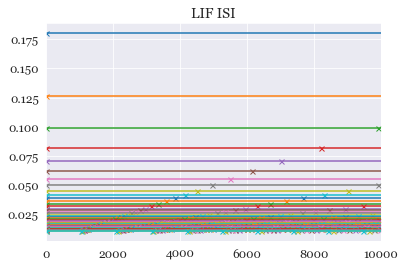

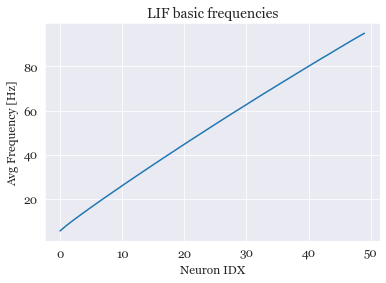

In [31]:
LIF_test = LIF_neuron(parameters).to(parameters['device'])
spk = []
v_mem = []
steady_current = []
myinput = torch.zeros((1,1)).to(parameters['device'])
sim = tqdm.trange(int(sim_time/parameters['clock_sim']), desc='Simulating LIF', leave=True)
with torch.no_grad():
    for i in sim:
        spk.append(LIF_test(myinput))
        v_mem.append(LIF_test.state.V)
        steady_current.append(LIF_test.steady_current)
    spk = torch.stack(spk)
    v_mem = torch.stack(v_mem)
    steady_current = LIF_test.steady_current
    events = torch.where(spk)
plt.scatter(events[0].cpu().detach().numpy(),events[2].cpu().detach().numpy(),s=1)
plt.title('LIF spikes')
plt.xlim([0,10000])
plt.figure()
plt.plot(v_mem[:,0,:].cpu().detach().numpy())
plt.title('LIF membrane potential')
plt.xlim([0,10000])
plt.figure()
plt.title('LIF ISI')
basic_freqs = []
for neu in range(parameters['neurons_n']):
    events_selected = events[0][torch.where(events[2]==neu)]
    isi_osc = torch.diff(events_selected)*parameters['clock_sim']
    plt.plot(events_selected[:-1].cpu().detach().numpy(),isi_osc.cpu().detach().numpy(),marker='x',markersize=5)
    basic_freqs.append(1/torch.mean(isi_osc).cpu().detach().numpy())
plt.xlim([0,10000])
plt.figure()
plt.plot(basic_freqs)
print(basic_freqs)
plt.title('LIF basic frequencies')
plt.xlabel('Neuron IDX')
plt.ylabel('Avg Frequency [Hz]')
torch.save(basic_freqs,'basic_freqs.pt')
torch.cuda.empty_cache()
basic_freqs = torch.tensor(basic_freqs)
plt.show()

## Defining TDE model and simulating it

In [32]:
parameters['C_TDE'] = 1
parameters['v_TDE_threshold'] = 1
parameters['tau_trg_TDE'] = 3e-3
parameters['tau_fac_TDE'] = 3e-3
parameters['gain_fac_TDE'] = 1
parameters['gain_trg_TDE'] = 100000
parameters['reset_TDE'] = 0
parameters['tau_TDE'] = 10e-3
parameters['refrac_TDE'] = 1e-3
parameters['trials_per_stimulus'] = 1

Simulating TDE:   0%|          | 0/99999 [00:00<?, ?it/s]

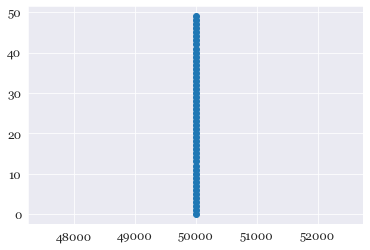

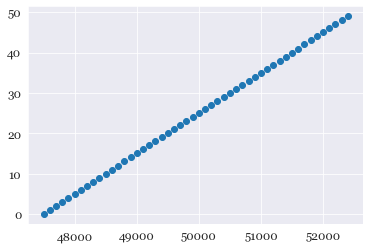

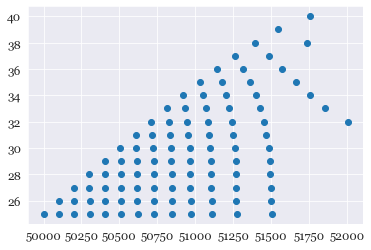

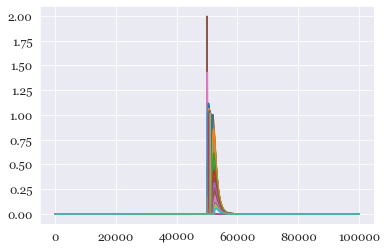

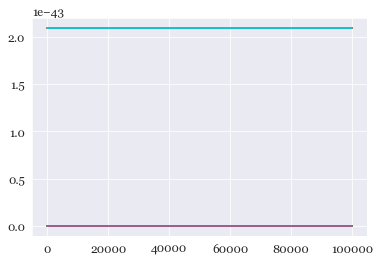

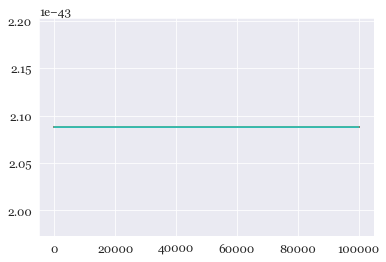

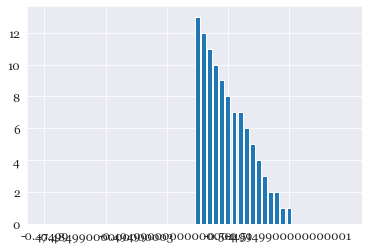

In [33]:
TDE_test = TDE(parameters)
fac_spikes = torch.zeros((int(sim_time/parameters['clock_sim']),1,parameters['neurons_n'])).to(parameters['device'])
trg_spikes = torch.zeros((int(sim_time/parameters['clock_sim']),1,parameters['neurons_n'])).to(parameters['device'])
fac_spikes[int(0.5*sim_time/parameters['clock_sim']),:] = 1
shift = 1e-3
shift = int(shift/parameters['clock_sim'])
offset = int(sim_time/(2*parameters['clock_sim']) - shift*fac_spikes.shape[2]/2)

for i in range(parameters['neurons_n']):
    trg_spikes[i*shift+offset,:,i] = 1

spk = []
v_mem = []
i_trg = []
i_fac = []
sim = tqdm.trange(int(sim_time/parameters['clock_sim']), desc='Simulating TDE', leave=True)
with torch.no_grad():
    for i in sim:
        spk.append(TDE_test(trg_spikes[i,:],fac_spikes[i,:]))
        v_mem.append(TDE_test.state.v)
        i_trg.append(TDE_test.state.i_trg)
        i_fac.append(TDE_test.state.i_fac)
    spk = torch.stack(spk)
    v_mem = torch.stack(v_mem)
    i_trg = torch.stack(i_trg)
    i_fac = torch.stack(i_fac)
    events_tde = torch.where(spk)
    events_fac = torch.where(fac_spikes)
    events_trg = torch.where(trg_spikes)
plt.scatter(events_fac[0].cpu().detach().numpy(),events_fac[2].cpu().detach().numpy())
plt.figure()
plt.scatter(events_trg[0].cpu().detach().numpy(),events_trg[2].cpu().detach().numpy())
plt.figure()
plt.scatter(events_tde[0].cpu().detach().numpy(),events_tde[2].cpu().detach().numpy())
plt.figure()
plt.plot(v_mem[:,0,:].cpu().detach().numpy())
plt.figure()
plt.plot(i_trg[:,0,:].cpu().detach().numpy())
plt.figure()
plt.plot(i_fac[:,0,:].cpu().detach().numpy())
plt.figure()
plt.bar([i for i in range(parameters['neurons_n'])],torch.sum(spk[:,0,:],dim=0).cpu().detach().numpy())
plt.xticks([i for i in range(parameters['neurons_n'])][::10],[int(0.5*sim_time) - (offset+i*shift)*parameters['clock_sim'] for i in range(parameters['neurons_n'])][::10])
torch.cuda.empty_cache()
plt.show()

## Defining SPLL model and simulating it

In [34]:
parameters['TDE_to_Osc_current'] = 2

In [35]:
def sim_sPLL(freqs,in_spikes,break_feedback = False,parameters_here = [],save_traces = False):
    torch.cuda.empty_cache()
    spk_tde = []
    spk_osc = []
    v_tde = []
    v_osc = []
    i_trg = []
    i_fac = []
    i_syn = []
    for j in range(len(freqs)):
        isi = torch.diff(torch.where(in_spikes[:,j,0])[0])*parameters['clock_sim']
        print('Frequency: ',1/torch.mean(isi).item(),' Hz')
    if len(parameters_here) == 0:
        parameters_here = parameters
    parameters_here['trials_per_stimulus'] = in_spikes.shape[1]
    sPLL_test = sPLL(parameters_here)
    sPLL_test.initialize_state(parameters = parameters_here)
    sim_loop = tqdm.trange(int(sim_time/parameters_here['clock_sim']),desc='Simulating sPLL')
    spk_tde_collect = []
    spk_osc_collect = []
    v_tde_collect = []
    v_osc_collect = []
    i_trg_collect = []
    i_fac_collect = []
    i_syn_collect = []
    with torch.no_grad():
        for i in sim_loop:
            spk_tde_tmp,spk_osc_tmp = sPLL_test(in_spikes[i])
            if break_feedback == True:
                sPLL_test.spikes_TDE_prev = torch.zeros_like(sPLL_test.spikes_TDE_prev)
            spk_tde.append(spk_tde_tmp)
            spk_osc.append(spk_osc_tmp)
            if save_traces == True:
                v_tde.append(sPLL_test.TDE.state.v)
                v_osc.append(sPLL_test.LIF.state.V)
                i_trg.append(sPLL_test.TDE.state.i_trg.clone().detach())
                i_fac.append(sPLL_test.TDE.state.i_fac.clone().detach())
                i_syn.append(sPLL_test.LIF.state.I.clone().detach())
            if (((i-1)%1000000 == 0)):
                # sim_loop.set_description('Simulating SPLL: {} ms'.format(i*parameters['clock_sim']*1000))
                spk_tde_collect.append(torch.stack(spk_tde).cpu().detach())
                spk_osc_collect.append(torch.stack(spk_osc).cpu().detach())
                if save_traces:
                    v_tde_collect.append(torch.stack(v_tde).cpu().detach())
                    v_osc_collect.append(torch.stack(v_osc).cpu().detach())
                    i_trg_collect.append(torch.stack(i_trg).cpu().detach())
                    i_fac_collect.append(torch.stack(i_fac).cpu().detach())
                    i_syn_collect.append(torch.stack(i_syn).cpu().detach())
                spk_tde = []
                spk_osc = []
                v_tde = []
                v_osc = []
                i_trg = []
                i_fac = []
                i_syn = []
                torch.cuda.empty_cache()
        spk_tde_collect.append(torch.stack(spk_tde).cpu().detach())
        spk_osc_collect.append(torch.stack(spk_osc).cpu().detach())
        if save_traces:
            v_tde_collect.append(torch.stack(v_tde).cpu().detach())
            v_osc_collect.append(torch.stack(v_osc).cpu().detach())
            i_trg_collect.append(torch.stack(i_trg).cpu().detach())
            i_fac_collect.append(torch.stack(i_fac).cpu().detach())
            i_syn_collect.append(torch.stack(i_syn).cpu().detach())
        spk_tde = torch.concat(spk_tde_collect,dim = 0)
        spk_osc = torch.concat(spk_osc_collect,dim = 0)
        if save_traces:
            v_tde = torch.concat(v_tde_collect,dim = 0)
            v_osc = torch.concat(v_osc_collect,dim = 0)
            i_trg = torch.concat(i_trg_collect,dim = 0)
            i_fac = torch.concat(i_fac_collect,dim = 0)
            i_syn = torch.concat(i_syn_collect,dim = 0)
            return spk_tde,spk_osc,v_tde,v_osc,i_trg,i_fac,i_syn
        else:
            return spk_tde,spk_osc



In [36]:
def generate_one_freq(f_ix, freq, trial_n, sim_time, clock_sim, noise=0, shift=0):
    trial_vec = torch.linspace(0, trial_n - 1, trial_n)
    trials = torch.ones([np.ceil(sim_time * freq).astype(int) + 1, trial_n])

    time_array_temp = torch.linspace(0, sim_time / clock_sim * freq,
                                     np.ceil(sim_time * freq).astype(int) + 1) * clock_sim / freq
    #print(time_array_temp)
    time_array = trials.T * time_array_temp
    shift = torch.rand(trial_n) * shift / freq
    shift = shift.unsqueeze(1).repeat(1, time_array.shape[1])
    check = (torch.randn(time_array.shape) * noise / freq) + noise / freq + shift
    time_array_noisy = time_array + check
    # plt.eventplot(time_array_noisy)
    # plt.show()
    freq_array = torch.ones(time_array.shape) * f_ix
    trial_array = (torch.ones(time_array.shape).T * trial_vec).T
    labels = torch.ones(trial_n) * f_ix
    time_array_noisy = time_array_noisy.flatten()
    freq_array = freq_array.flatten()
    trial_array = trial_array.flatten()
    return time_array_noisy, freq_array, trial_array, labels


def generate_freqs(f1, f2=[], trials_n=1, sim_time=1, sampling_freq=1000, noise=0, shift=0):
    data_combined = []
    labels_combined = []
    time_list = []
    trials_list = []
    labels_list = []
    time_list_combined = []
    trials_list_combined = []

    for fr_ix in range(len(f1)):
        freq = f1[fr_ix]
        time, _, trials, labels = generate_one_freq(fr_ix, freq, trials_n, sim_time, 1 / sampling_freq, noise, shift)
        time_pos = time > 0
        time = time[time_pos]
        trials = trials[time_pos]
        correct_idx = torch.argsort(time)
        time = time[correct_idx]
        trials = trials[correct_idx]
        time_list.append(time)
        trials_list.append(trials)
        labels_list.append(labels)
        # print(fr_ix)
        data_combined.append(
            torch.sparse_coo_tensor(indices=torch.stack([(time * sampling_freq).to(torch.int), trials]),
                                    values=torch.ones_like(time).float(),
                                    size=torch.Size([int(sim_time * sampling_freq), trials_n])).to_dense())
        # print(data_combined[-1])
        labels_combined.append(labels)
        # print('fr1',f1[fr_ix])
    if len(f2) > 0:
        # print('Generating now f2')
        data_combined = []
        labels_combined = []
        for fr_ix in range(len(f2)):
            # print(f1)
            freq = f2[fr_ix]
            time, _, trials, labels = generate_one_freq(fr_ix, freq, trials_n, sim_time, 1 / sampling_freq, noise,
                                                        shift)
            time_pos = time > 0
            time = time[time_pos]
            trials = trials[time_pos]
            for fr_ix2, freq2 in enumerate(f1):
                time = torch.cat((time_list[fr_ix2], time))
                trials = torch.cat((trials_list[fr_ix2], trials))
                correct_idx = torch.argsort(time)
                time = time[correct_idx]
                trials = trials[correct_idx]
                time_list_combined.append(time)
                trials_list_combined.append(trials)
                data_combined.append(
                    torch.sparse_coo_tensor(indices=torch.stack([(time * sampling_freq).to(torch.int), trials]),
                                            values=torch.ones_like(time).float(),
                                            size=torch.Size([int(sim_time * sampling_freq), trials_n])).to_dense())
                labels_combined.append(labels * (len(freqs) - 1) + labels_list[fr_ix2])
                # print('label',labels * len(freqs) + labels_list[fr_ix2])
                # print('fr2',f2[fr_ix], 'fr1',f1[fr_ix2])
    return data_combined, labels_combined

In [37]:
def plot_spll_run(in_spikes,spk_tde,spk_osc,i_syn,i_fac,i_trg,freqs = [],suptitle='',cmap = 'Greens',xlims=[],ylims_isi=[],select_spll = [],moving_avg = 1):
    if len(select_spll) == 0:
        select_spll = np.arange(0,in_spikes.shape[2])
    events_in = torch.where(in_spikes)
    events_tde = torch.where(spk_tde)
    events_osc = torch.where(spk_osc)
    stimuli = torch.unique(events_osc[1])

    max = 5
    print(len(stimuli))
    if len(stimuli) < max:
        max = len(stimuli)
    if len(stimuli) == 1:
        max = 2
    print(max)
    fig1,axis1 = plt.subplots(8,max,figsize = (16,16),sharex='all',sharey='row')
    if suptitle != '':
        fig1.suptitle(suptitle)
    axis1[0,0].set_ylabel('IN Spikes')
    axis1[1,0].set_ylabel('TDE Spikes')
    axis1[2,0].set_ylabel('TDE moving avg')
    axis1[3,0].set_ylabel('OSC Spikes')
    axis1[4,0].set_ylabel('I SYN')
    axis1[5,0].set_ylabel('I FAC')
    axis1[6,0].set_ylabel('I TRG')
    axis1[7,0].set_ylabel('1/ISI')
    events_in_selected = [events_in[0][torch.where(events_in[2] == 0)],events_in[1][torch.where(events_in[2] == 0)]]
    kernel = moving_avg
    sma = nn.AvgPool1d(kernel_size=kernel, stride = 1)

    if len(xlims) > 0:
        axis1[0,0].set_xlim(xlims)
    if len(ylims_isi) > 0:
        axis1[7,0].set_ylim(ylims_isi)
    for stimulus in stimuli[0:max]:
        events_in_selected_stimulus = events_in_selected[0][torch.where(events_in_selected[1]==stimulus)]

        isi_in = torch.diff(events_in_selected_stimulus)
        events_tde_selected = [events_tde[0][torch.where(events_tde[1]==stimulus)],events_tde[2][torch.where(events_tde[1]==stimulus)]]
        events_osc_selected = [events_osc[0][torch.where(events_osc[1]==stimulus)],events_osc[2][torch.where(events_osc[1]==stimulus)]]
        axis1[0,stimulus].scatter(events_in_selected_stimulus.cpu().detach().numpy(),torch.ones_like(events_in_selected_stimulus).cpu().detach().numpy(),marker='.')
        axis1[1,stimulus].scatter(events_tde_selected[0].cpu().detach().numpy(),(events_tde_selected[1]).cpu().detach().numpy(),marker='.')
        if len(freqs) > 0:
            axis1[0,stimulus].set_title(str(freqs[stimulus]) + ' Hz')
        moving_average_tde = sma(spk_tde[:,stimulus,:])
        axis1[2,stimulus].plot(moving_average_tde.cpu().detach().numpy())
        axis1[3,stimulus].scatter(events_osc_selected[0].cpu().detach().numpy(),(events_osc_selected[1]).cpu().detach().numpy(),marker='.')
        axis1[4,stimulus].plot(i_syn[:,stimulus,:].cpu().detach().numpy())
        axis1[5,stimulus].plot(i_fac[:,stimulus,:].cpu().detach().numpy())
        axis1[6,stimulus].plot(i_trg[:,stimulus,:].cpu().detach().numpy())
        #calculate isi
        for neuron in select_spll:
            events_cco_here = events_osc_selected[0][(torch.where(events_osc_selected[1]==neuron))]
            isi_cco = torch.diff(events_cco_here)
            axis1[7,stimulus].plot(events_cco_here[:-1],1/(isi_cco.cpu().detach().numpy()*parameters['clock_sim']),marker='x')
        axis1[7,stimulus].plot(events_in_selected_stimulus[:-1].cpu().detach().numpy(),1/(isi_in*parameters['clock_sim']).cpu().detach().numpy(),linestyle='--',color='k',marker='x')
    spk_tde_sum = torch.sum(spk_tde,dim=0).cpu().detach().numpy()
    spk_tde_sum_norm = spk_tde_sum.T/np.max(spk_tde_sum,axis=1)
    spk_tde_sum_norm = spk_tde_sum_norm.T/basic_freqs
    plt.figure()
    plt.imshow(spk_tde_sum_norm,aspect='auto',cmap=cmap)
    # plt.xticks([i for i in range(spk_tde_sum_w.shape[1])][:-1:10],[int(basic_freqs[i]) for i in range(0,spk_tde_sum_w.shape[1]-1,10)])
    # plt.yticks([i for i in range(spk_tde_sum_w.shape[0])][::10],freqs[::10])
    plt.colorbar()

# SINGLE FREQUENCY WITH THE sPLL

In [38]:
torch.cuda.empty_cache()

freqs = np.arange(30,57,3)
# in_spikes = torch.zeros((int(sim_time/parameters['clock_sim']),len(freqs),parameters['neurons_n'])).to(parameters['device'])
freqs_list = []
in_spikes_list = []
parameters['sim_time'] = 0.1
for freq1 in freqs:
    freqs_sparse = torch.arange(0,sim_time/parameters['clock_sim'],np.ceil(1/parameters['clock_sim']/freq1))
    in_spikes = torch.sparse_coo_tensor(freqs_sparse.unsqueeze(0),torch.ones_like(freqs_sparse),size=([int(sim_time/parameters['clock_sim'])])).to_dense()
    freqs_list.append(freqs_sparse)
    in_spikes_list.append(in_spikes)
in_spikes_s = torch.stack(in_spikes_list,dim=0).T
in_spikes_s = in_spikes_s.unsqueeze(2)*torch.ones((1,1,parameters['neurons_n']))
print(in_spikes_s.shape)
in_spikes_s[in_spikes_s>0] = 1
in_spikes_s = in_spikes_s.to(parameters['device'])
spk_tde_w,spk_osc_w,v_tde_w,v_osc_w,i_trg_w,i_fac_w,i_syn_w = sim_sPLL(in_spikes=in_spikes_s,freqs=freqs,break_feedback = False,save_traces=True)
# spk_tde_wo,spk_osc_wo,v_tde_wo,v_osc_wo,i_trg_wo,i_fac_wo,i_syn_wo = sim_sPLL(in_spikes=in_spikes_s,freqs=freqs,break_feedback = True,save_traces=True)
torch.cuda.empty_cache()

torch.Size([99999, 9, 50])
Frequency:  29.994001545090427  Hz
Frequency:  32.99241041267145  Hz
Frequency:  35.997122487968404  Hz
Frequency:  38.98635730343573  Hz
Frequency:  41.999154808244576  Hz
Frequency:  44.984253150136645  Hz
Frequency:  47.98464408194566  Hz
Frequency:  50.99439344728809  Hz
Frequency:  53.995681921751  Hz


Simulating sPLL:   0%|          | 0/99999 [00:00<?, ?it/s]

In [39]:
_,spk_osc_t_nofb = sim_sPLL(in_spikes=in_spikes_s,freqs=freqs,break_feedback = True,save_traces=False)


Frequency:  29.994001545090427  Hz
Frequency:  32.99241041267145  Hz
Frequency:  35.997122487968404  Hz
Frequency:  38.98635730343573  Hz
Frequency:  41.999154808244576  Hz
Frequency:  44.984253150136645  Hz
Frequency:  47.98464408194566  Hz
Frequency:  50.99439344728809  Hz
Frequency:  53.995681921751  Hz


Simulating sPLL:   0%|          | 0/99999 [00:00<?, ?it/s]

In [40]:
# cmap = ListedColormap(sns.color_palette('mako_r').as_hex())
# plot_spll_run(in_spikes_s,spk_tde_w,spk_osc_w,i_syn_w,i_fac_w,i_trg_w,freqs,suptitle='One freq with Feedback',cmap='Greens',ylims_isi=[20,50])
# cmap = ListedColormap(sns.color_palette('rocket_r').as_hex())
# plot_spll_run(in_spikes_s,spk_tde_wo,spk_osc_wo,i_syn_wo,i_fac_wo,i_trg_wo,freqs,suptitle='One freq without Feedback',cmap='Oranges',ylims_isi=[20,50])

torch.Size([9, 50])


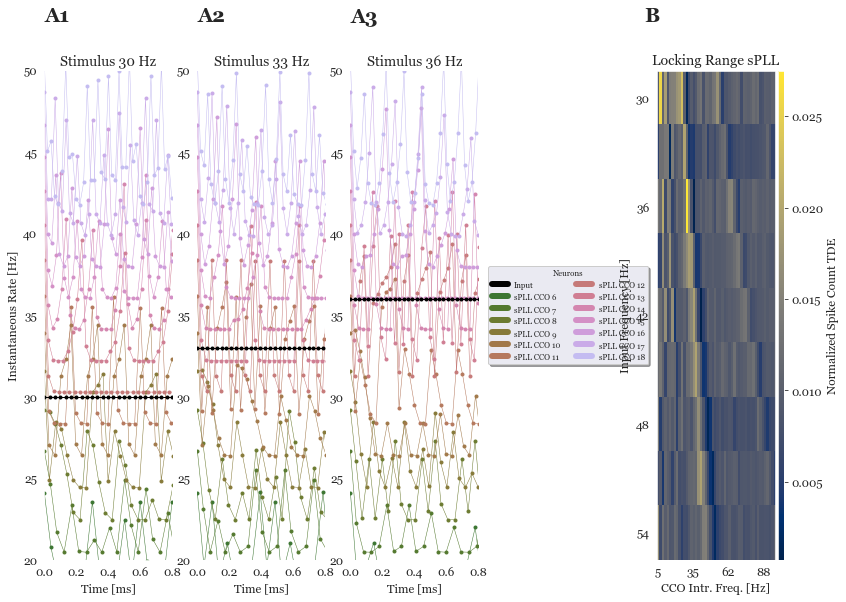

<Figure size 432x288 with 0 Axes>

In [41]:
## Plotting Locking
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
#change font to arxiv one

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', family='georgia', size=SMALL_SIZE)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
import seaborn as sns
# colors = sns.cubehelix_palette(20, start=0.5, rot=-0.75)
stimulus_n = 1
neurons_start = 6
neurons_n = 19
colors = sns.color_palette("cubehelix",neurons_n+10)[10:]

# fig1,axis1= plt.subplots(1,stimulus_n,figsize=(8,3),sharey='all')
fig1 = plt.figure(figsize=(16,9))
gs = fig1.add_gridspec(1, 6)
axis1 = []
axis1.append(fig1.add_subplot(gs[0, 0]))
axis1.append(fig1.add_subplot(gs[0, 1]))
axis1.append(fig1.add_subplot(gs[0, 2]))
axis1.append(fig1.add_subplot(gs[0, 4:5]))
custom_lines = []
custom_labels = []
custom_lines.append(Line2D([0], [0], color='k', lw=6))
custom_labels.append('Input')
for i,neu in enumerate(range(neurons_start,neurons_n)):
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=6))
    # custom_lines.append(Line2D([0], [0], color='k', lw=6,linestyle = linestyles_coll[i]))
    # custom_labels.append(str(freqs[int(i)]) + ' Hz')
    custom_labels.append('sPLL CCO ' + str(neu))
events_in = torch.where(in_spikes_s)
events_osc = torch.where(spk_osc_w)
stimuli = torch.unique(events_osc[1])
events_in_selected = [events_in[0][torch.where(events_in[2] == 0)],events_in[1][torch.where(events_in[2] == 0)]]
axis1[0].set_ylim([25,55])
# plt.xlim([0,80000])
linestyles = ['--','-.',':']

for st_idx,stimulus in enumerate(stimuli[:stimulus_n*3:stimulus_n]):
    row = int(stimulus/2)
    col = stimulus%2
    events_in_selected_stimulus = events_in_selected[0][torch.where(events_in_selected[1]==stimulus)]
    isi_in = torch.diff(events_in_selected_stimulus)
    isi_in_mean = torch.mean(isi_in.to(torch.float32))
    events_osc_selected = [events_osc[0][torch.where(events_osc[1]==stimulus)],events_osc[2][torch.where(events_osc[1]==stimulus)]]
    for n_idx,neuron in enumerate(range(neurons_start,neurons_n)):
        events_cco_here = events_osc_selected[0][(torch.where(events_osc_selected[1]==neuron))]
        isi_cco = torch.diff(events_cco_here)
        isi_cco_mean = torch.mean(isi_cco.to(torch.float32))
        distance = (np.abs(isi_cco_mean-isi_in_mean)/isi_cco_mean)
        distance = torch.tensor([0])
        axis1[st_idx].plot(events_cco_here[:-1],1/(isi_cco.cpu().detach().numpy()*parameters['clock_sim']),color=colors[n_idx],alpha=max((1-distance.item())**2,0),marker='.',linewidth=0.5)
    axis1[st_idx].plot(events_in_selected_stimulus[:-1],1/(isi_in*parameters['clock_sim']),color='k',alpha=1,marker='.',linewidth=1)
    axis1[st_idx].set_title('Stimulus {} Hz'.format(freqs[stimulus]))
# plt.tight_layout()
#remove boxes
letters = ['A1','A2','A3','B']
for ax in axis1[:3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Time [ms]')
    ax.patch.set_visible(False)

    # ax.set_ylim([50,60])
    ax.set_xlim([0,80000])
    ax.set_xticks([0,20000,40000,60000,80000])
    ax.set_xticklabels(np.round((np.array([0,20000,40000,60000,80000])*parameters['clock_sim']),2))
    ax.set_ylim([20,50])
    ax.grid(False)
    ax.text(-0.0, 1.1, letters.pop(0), transform=ax.transAxes, 
            size=20, weight='bold')
axis1[3].text(-0.1, 1.1, letters.pop(0), transform=axis1[3].transAxes, 
            size=20, weight='bold')

axis1[1].spines['left'].set_visible(False)
axis1[2].spines['left'].set_visible(False)
axis1[0].set_ylabel('Instantaneous Rate [Hz]')
axis1[2].legend(custom_lines, custom_labels,loc='center left',
          fancybox=True, shadow=True, ncol=2,title='Neurons',bbox_to_anchor=(1.05, 0.5))
# axis1[3].spines['left'].set_visible(False)
# axis1[3].spines['right'].set_visible(False)
# axis1[3].spines['top'].set_visible(False)
# axis1[3].spines['bottom'].set_visible(False)
# axis1[3].set_xticks([])
spk_tde_sum = torch.sum(spk_tde_w,dim=0).cpu().detach().numpy()
spk_tde_sum_norm = spk_tde_sum.T/np.max(spk_tde_sum,axis=1)
spk_tde_sum_norm = spk_tde_sum_norm.T/basic_freqs
print(spk_tde_sum_norm.shape)
plt.figure()
img = axis1[3].imshow(spk_tde_sum_norm,aspect='auto',cmap='cividis',interpolation='none')
axis1[3].set_ylabel('Input Frequency [Hz]')
axis1[3].set_xlabel('CCO Intr. Freq. [Hz]')
axis1[3].set_yticks([i for i in range(0,len(freqs),2)])
axis1[3].set_yticklabels([freqs[i] for i in range(0,len(freqs),2)])
axis1[3].set_xticks([i for i in range(0,len(basic_freqs),15)])
axis1[3].set_xticklabels([int(basic_freqs[i].item()) for i in range(0,len(basic_freqs),15)])
axis1[3].set_title('Locking Range sPLL')
axis1[3].grid(False)
divider = make_axes_locatable(axis1[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig1.colorbar(img, cax=cax, orientation='vertical',label='Normalized Spike Count TDE')
# fig1.tight_layout()
fig1.savefig('locking_freqsweep.pdf',bbox_inches='tight',dpi=300)


In [42]:
in_spikes_s.shape

torch.Size([99999, 9, 50])

In [46]:
in_spikes_s.shape[0]*parameters['clock_sim']

0.99999

[ 0.04 -0.04  0.04  0.04  0.04  0.04 -0.04  0.04 -0.04  0.04  0.04  0.04
 -0.04  0.04]
290
nofb_arrowslice [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
1
10
30.0
[ 0.04  0.04  0.04  0.04 -0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04
  0.04  0.04  0.04  0.04  0.04  0.04 -0.04  0.04  0.04  0.04  0.04  0.04
  0.04  0.04  0.04 -0.04 -0.04 -0.04]
len arrowslice (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),)
604
[-0.49910018 -0.45890822 -0.4295141  -0.40131974 -0.36622675 -0.33353329
 -0.28974205 -0.24475105 -0.20575885 -0.17246551 -0.14307139 -0.11487702
 -0.07978404 -0.05968806 -0.03629274 -0.01379724  0.01409718  0.03689262
  0.05878824  0.09058188  0.11757648  0.15956809  0.19946011  0.23485303
  0.28014397  0.30113977  0.33563287  0.38812238  0.42231554  0.44991002
  0.49370126]
(300, 300, 4)


/tmp/ipykernel_7945/321170168.py:441: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1a.tight_layout()


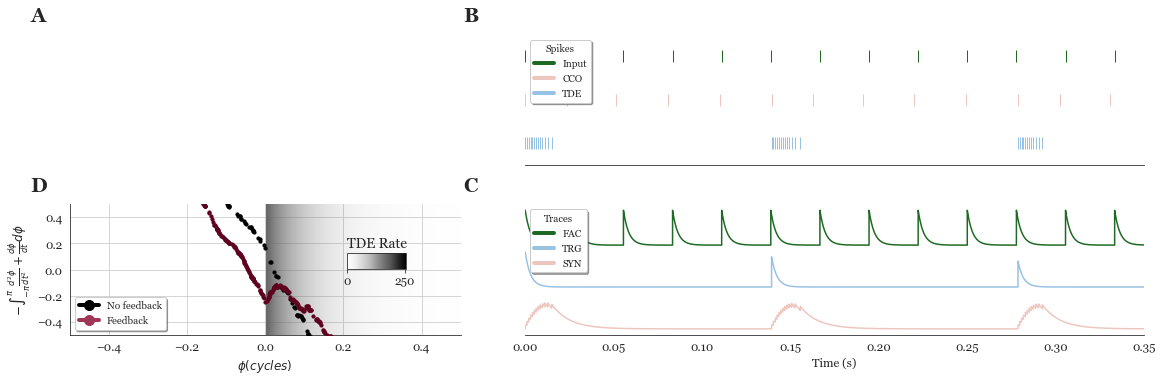

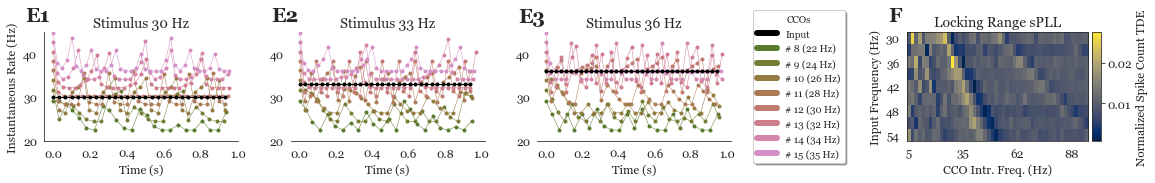

In [45]:
#working with offsets, now 3 for a paper
# plt.rcParams['text.usetex'] = True
# plt.rcParams.update({'font.size': 45})
import matplotlib as mpl
#import integ
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integ

import seaborn as sns
sns.set_style('white')
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
textwidth = 6.50127 #inches
global_width = textwidth*2.5
global_height = global_width*1.5/3
plt.rc('font', family='Georgia', size=SMALL_SIZE)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#keep colors same as in other plots
fig1a = plt.figure(figsize=(global_width,global_height*2/3))
gs = fig1a.add_gridspec(2, 10)




colors = mpl.colormaps['magma'](np.linspace(0.2,0.8,3))

select_try_global = 14
select_shift = 2
spk_osc_t = spk_osc_w
in_spikes_t = in_spikes_s
spk_tde_t = spk_tde_w
i_trg_t = i_trg_w
i_fac_t = i_fac_w
i_syn_t = i_syn_w
#set up things, we don' t really use this for this plot
noruns = spk_osc_t.shape[2]
noshifts = spk_osc_t.shape[1]
skip = 1 #get every skip trace
# fig, axs = plt.subplots(2,2,figsize =(30,12),sharex=True, sharey=True)

extspikes = np.argwhere(in_spikes_t.cpu()[:,0,0].numpy()).flatten()
period = np.average(np.diff(extspikes))*parameters['clock_sim'] #period for the wrapping
frequency = 1/period #freq for title
k = 0
colors = {'IN':'#1e6923','TDE':'#98c2e2','CCO':'#edc7bf'}
letters = ['A','B','C','D','E','F','G']
axis1 = []
axis1.append(fig1a.add_subplot(gs[0, 0:4]))
axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
            size=20, weight='bold')
axis1[-1].axis('off')
axis1.append(fig1a.add_subplot(gs[0, 4:10]))
spikes_in = torch.where(in_spikes_t[:,select_shift,select_try_global])
spikes_tde = torch.where(spk_tde_t[:,select_shift,select_try_global])
spikes_osc = torch.where(spk_osc_t[:,select_shift,select_try_global])
axis1[-1].plot(spikes_in[0]*parameters['clock_sim'],np.zeros_like(spikes_in[0])+2,'|',markersize=12,color=colors['IN'])
axis1[-1].plot(spikes_osc[0]*parameters['clock_sim'],np.zeros_like(spikes_osc[0])+1,'|',markersize=12,color=colors['CCO'])
axis1[-1].plot(spikes_tde[0]*parameters['clock_sim'],np.zeros_like(spikes_tde[0]),'|',markersize=12,color=colors['TDE'])
axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
            size=20, weight='bold')
axis1[-1].set_xlim(0,0.35)

custom_lines = []
from matplotlib.lines import Line2D
custom_lines.append(Line2D([0], [0], color=colors['IN'], lw=4,solid_capstyle='round'))
custom_lines.append(Line2D([0], [0], color=colors['CCO'], lw=4,solid_capstyle='round'))
custom_lines.append(Line2D([0], [0], color=colors['TDE'], lw=4,solid_capstyle='round'))
axis1[-1].legend(custom_lines,[
     'Input',
     'CCO',
    'TDE',
],fancybox=True,loc='upper left',title='Spikes',shadow=True)
axis1[-1].spines['left'].set_visible(False)

axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
# axis1[-1].set_xlim(4400*parameters['clock_sim'],10000*parameters['clock_sim'])
axis1[-1].set_ylim(-0.5,2.5)
axis1[-1].set_xticks([])
axis1[-1].set_yticks([])
axis1[-1].grid(False)

# colors = mpl.colormaps['viridis'](np.linspace(0.2,0.8,3))
axis1.append(fig1a.add_subplot(gs[1, 4:10]))
custom_lines = []
from matplotlib.lines import Line2D
custom_lines.append(Line2D([0], [0], color=colors['IN'], lw=4,solid_capstyle='round'))
custom_lines.append(Line2D([0], [0], color=colors['TDE'], lw=4,solid_capstyle='round'))
custom_lines.append(Line2D([0], [0], color=colors['CCO'], lw=4,solid_capstyle='round'))
axis1[-1].legend(custom_lines,[
     'FAC',
     'TRG',
    'SYN',
],fancybox=True,loc='upper left',title='Traces',shadow=True)
axis1[-1].plot(np.array([i for i in range(i_trg_t.shape[0])])*parameters['clock_sim'],i_fac_t[:,select_shift,select_try_global]/i_fac_t.max()+2.4,color=colors['IN'])
# axis1[-1].set_xlim(4400*parameters['clock_sim'],10000*parameters['clock_sim'])
axis1[-1].set_yticks([])
# axis1[-1].set_xticks([])
axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
            size=20, weight='bold')
axis1[-1].spines['left'].set_visible(False)
axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
# axis1[-1].set_yticks([])
axis1[-1].set_xlabel('Time (s)')
# axis1.append(fig1.add_subplot(gs[4, 1:3]))
axis1[-1].plot(np.array([i for i in range(i_trg_t.shape[0])])*parameters['clock_sim'],i_trg_t[:,select_shift,select_try_global]/i_trg_t[:,select_shift,select_try_global].max() + 1.2,color=colors['TDE'])
# axis1[-1].set_xlim(0,10000)
# axis1[-1].set_xticks([])
# axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
#             size=20, weight='bold')
axis1[-1].grid(False)
axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
# axis1.append(fig1.add_subplot(gs[5, 1:3]))
axis1[-1].plot(np.array([i for i in range(i_trg_t.shape[0])])*parameters['clock_sim'],i_syn_t[:,select_shift,select_try_global]/i_syn_t.max(),color=colors['CCO'])
# axis1[-1].set_xlim(0,10000)
# axis1[-1].set_xticks([])
# axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
#             size=20, weight='bold')
axis1[-1].set_xlim(0,0.35)
axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
axis1.append(fig1a.add_subplot(gs[1, 0:4]))
selected_trials = [1,select_try_global,34]
selected_trials = [select_try_global]
axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
            size=20, weight='bold')
axis1[-1].grid(False)
axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
for k,i in enumerate(selected_trials):
    #get axis, use a separate iterator because i is unreliable
#     ax = axs[1,1]
# )
    ax = axis1[-1]
    #set up arrays
    phase = np.empty(0)
    dphase = np.empty(0)
    ddphase = np.empty(0)
    for j in range(noshifts):
        #get spikes for both cco and input
        intspikes = np.argwhere(spk_osc_t_nofb[:,j,skip*i].numpy()).flatten()
        extspikes = np.argwhere(in_spikes_t.cpu()[:,j,skip*i].numpy()).flatten()
        
        #cut to size, such that we only look at the part where both are active
        lenint = len(intspikes)
        lenext = len(extspikes)
        if lenint>lenext:
            intspikes=intspikes[:lenext]
        elif lenext>lenint:
            extspikes=extspikes[:lenint]
        phaseloc = np.empty_like(extspikes)
        for n in range(len(extspikes)):
            phaseloc[n] = extspikes[n]

        #get loc(al) phase, dphase, and ddphase, add to global arrays
        phaseloc = (intspikes-extspikes)*parameters['clock_sim']
        phase = np.append(phase,phaseloc[1:-1])
        dphaseloc = np.diff(phaseloc)/period
        dphase = np.append(dphase,dphaseloc[1:])
        ddphaseloc = np.diff(dphaseloc)
        ddphase = np.append(ddphase,ddphaseloc)

    #'wrap' to -pi,pi
    phasefix = (((phase+period/2)%period)-period/2)/period
    psorting = np.argsort(phasefix)
    phasefix = phasefix[psorting]
    dphase = dphase[psorting]
    ddphase = ddphase[psorting]
    integddphase = integ.cumulative_trapezoid((dphase+ddphase)/period,x=phasefix,initial=0)
    integddphase -= np.average(integddphase)

    #create arrow arrays
    #first we set the step size, smaller for the locking plot
    arrowstep = 20

    #get x and y
    arrowx = phasefix[::arrowstep]
    arrowy = -integddphase[::arrowstep]

    #have it point the direction of movement
    arrowsign = (dphase/np.abs(dphase))[::arrowstep][:-1]*0.04#*scale
    print(arrowsign)
    #the tangent of the curve
    arrowu = np.diff(arrowx)
    arrowv = np.diff(arrowy)
    arrowsign /= np.sqrt(arrowu**2+arrowv**2)
    arrowu *= arrowsign
    arrowv *= arrowsign

    #locking plot becomes a mess near x=0
    # if k == 2:
    arrowslice = (np.abs(arrowx)>0.01)
    arrowx = arrowx[arrowslice]
    arrowy = arrowy[arrowslice]
    arrowu = arrowu[arrowslice[:-1]]
    arrowv = arrowv[arrowslice[:-1]]

    #main curve
    print(len(phasefix))
    nofb = ax.scatter(phasefix,-integddphase,linewidth=1,color='k',zorder=4,s=10)
    print('nofb_arrowslice',arrowslice)
    #arrows
    # nofb = ax.quiver(arrowx[:-1],arrowy[:-1],arrowu,arrowv,scale=1,width=0.1,minlength=0.01,headwidth=3,headaxislength=3,color='k',zorder=3)
    
    
    
    #we loop through all our different shifts, so we can stick em together after
    for j in range(noshifts):
        #get spikes for both cco and input
        intspikes = np.argwhere(spk_osc_t[:,j,skip*i].numpy()).flatten()
        extspikes = np.argwhere(in_spikes_t.cpu()[:,j,skip*i].numpy()).flatten()
        
        #cut to size, such that we only look at the part where both are active
        lenint = len(intspikes)
        lenext = len(extspikes)
        if lenint>lenext:
            intspikes=intspikes[:lenext]
        elif lenext>lenint:
            extspikes=extspikes[:lenint]
        phaseloc = np.empty_like(extspikes)
        for n in range(len(extspikes)):
            phaseloc[n] = extspikes[n]

        #get loc(al) phase, dphase, and ddphase, add to global arrays
        phaseloc = (intspikes-extspikes)*parameters['clock_sim']
        phase = np.append(phase,phaseloc[1:-1])
        dphaseloc = np.diff(phaseloc)/period
        dphase = np.append(dphase,dphaseloc[1:])
        ddphaseloc = np.diff(dphaseloc)
        ddphase = np.append(ddphase,ddphaseloc)

    #'wrap' to -pi,pi
    phasefix = (((phase+period/2)%period)-period/2)/period
    psorting = np.argsort(phasefix)
    phasefix = phasefix[psorting]
    dphase = dphase[psorting]
    ddphase = ddphase[psorting]
    integddphase = integ.cumulative_trapezoid((dphase+ddphase)/period,x=phasefix,initial=0)
    integddphase -= np.average(integddphase)

    #create arrow arrays
    #first we set the step size, smaller for the locking plot
    
    ##close to locking
    arrowstep= 20

    #get x and y
    arrowx = phasefix[::arrowstep]
    arrowy = -integddphase[::arrowstep]

    #have it point the direction of movement
    arrowsign = (dphase/np.abs(dphase))[::arrowstep][:-1]*0.04#*scale
    closest_value = arrowsign.shape[0]//arrowstep
    remaining = arrowsign.shape[0]%arrowstep
    print(closest_value)
    print(remaining)
    print(arrowsign.shape[0]/closest_value)
    # arrowsign = arrowsign[:-remaining].reshape(closest_value,int(arrowsign.shape[0]/closest_value)).mean(axis=1)
    print(arrowsign)
    #the tangent of the curve
    arrowu = np.diff(arrowx)
    arrowv = np.diff(arrowy)
    arrowsign /= np.sqrt(arrowu**2+arrowv**2)
    arrowu *= arrowsign
    arrowv *= arrowsign

    #locking plot becomes a mess near x=0

    arrowslice = (np.abs(arrowx)>0.001) #& (np.abs(arrowx)<0.05)
    print('len arrowslice',np.where(arrowslice))
    arrowx = arrowx[arrowslice]
    arrowy = arrowy[arrowslice]
    arrowu = arrowu[arrowslice[:-1]]
    arrowv = arrowv[arrowslice[:-1]]

    #main curve
    print(len(phasefix))
    fb = ax.scatter(phasefix,-integddphase,linewidth=1,color='#5F021F',zorder=4,s=10)
    print(arrowx)
    #arrows
    # fb = ax.quiver(arrowx[:-1],arrowy[:-1],arrowu,arrowv,scale=1,width=0.1,minlength=0.01,headwidth=3,headaxislength=3,color='#5F021F',zorder=3)
    # select_arrowx = np.where(np.abs(arrowx-0.5)<0.01)
    # fb = ax.quiver(arrowx[:-1],arrowy[:-1],arrowu,arrowv,scale=1,width=0.1,minlength=0.01,headwidth=3,headaxislength=3,color='#5F021F',zorder=3)


    #shading
    pixels = 300
    half = int(pixels/2)
    grays = np.full((pixels,pixels, 4), 100, dtype=np.uint8)
    alphas = np.zeros((pixels,pixels,))
    
    alphas[:,half:] = 255*np.exp(-np.linspace(0,0.5,half)*period/parameters['tau_fac_TDE'])
    alphas[:,:half] = 255*np.exp(-np.linspace(0.5,1,half)*period/parameters['tau_fac_TDE'])
    grays[:,:,3] = alphas
    print(grays.shape)
    cm = ax.imshow(grays,extent=(-0.5, 0.5, -0.5, 0.8),zorder = 1,aspect='auto',cmap='Greys')
#     ax.imshow(grays)
    #make nice
    ax.set_ylim((-0.5,0.5))
    ax.set_xlim((-0.5,0.5))
#     ax.set_title(f"I = {parameters['I_minimum_osc']+parameters['I_step_osc']*i}")
    ax.grid(True)
custom_lines = []
custom_lines.append(Line2D([0], [0], color='k', lw=4,solid_capstyle='round',marker='o',markersize=10))
custom_lines.append(Line2D([0], [0], color='#A13558', lw=4,solid_capstyle='round',marker='o',markersize=10))
ax.legend(custom_lines,['No feedback','Feedback'],loc='lower left',fancybox=True,shadow=True)
#make whole plot nice
# plt.suptitle(f'Potential well plots with f = {frequency:.2f} Hz',size = 100)
axis1[-1].set_xlabel(r'$\phi (cycles)$')
axis1[-1].set_ylabel(r'$-\int^\pi_{-\pi} \frac{d^2\phi}{dt^2} +  \frac{d\phi}{dt}  d\phi$')
cbaxes = fig1a.add_axes([0.3, 0.3, 0.05, 0.04])
cbaxes.set_title('TDE Rate')
# formatter = LogFormatter(10, labelOnlyBase=False)
import matplotlib.colors as colors_package
sm = plt.cm.ScalarMappable(cmap='Greys', norm=colors_package.Normalize(vmin=grays.min(), vmax=grays.max()))
fig1.colorbar(cm,cax=cbaxes, orientation='horizontal',cmap='Greys')
cbaxes.yaxis.set_ticks_position('left')
cbaxes.yaxis.set_label_position('left')

# axis1.append(fig1.add_subplot(gs[2:4,3]))
# custom_lines = []
# from matplotlib.lines import Line2D
# custom_lines.append(Line2D([0], [0], color=colors[0], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[1], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[2], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[0], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[1], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[2], lw=4,solid_capstyle='round'))
# axis1[-1].axis('off')
# axis1[-1].legend(custom_lines,[
#    'Linear',
#      'Input Spikes',
#      'CCO Spikes',
#     'TDE Spikes',
#     'FAC Trace',
#     'TRG Trace',
#     'SYN Trace'
# ],fancybox=True,loc='best',title='Model', framealpha=0.8)

# colors = sns.cubehelix_palette(20, start=0.5, rot=-0.75)
stimulus_n = 1
neurons_start = 8
neurons_n = 16
colors = sns.color_palette("cubehelix",neurons_n+10)[10:]

# fig1,axis1= plt.subplots(1,stimulus_n,figsize=(8,3),sharey='all')
fig1b = plt.figure(figsize=(global_width,global_height*1/3))
grid_per_fig = 2
gs = fig1.add_gridspec(1, 4*grid_per_fig+1)
axis1 = []
axis1.append(fig1b.add_subplot(gs[0, grid_per_fig*0:grid_per_fig*1]))
axis1.append(fig1b.add_subplot(gs[0, grid_per_fig*1:grid_per_fig*2]))
axis1.append(fig1b.add_subplot(gs[0, grid_per_fig*2:grid_per_fig*3]))
axis1.append(fig1b.add_subplot(gs[0, grid_per_fig*3+1:grid_per_fig*4+1]))
custom_lines = []
custom_labels = []
custom_lines.append(Line2D([0], [0], color='k', lw=6))
custom_labels.append('Input')
for i,neu in enumerate(range(neurons_start,neurons_n)):
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=6))
    # custom_lines.append(Line2D([0], [0], color='k', lw=6,linestyle = linestyles_coll[i]))
    # custom_labels.append(str(freqs[int(i)]) + ' Hz')
    custom_labels.append('# ' + str(neu) + ' (' + str(int(np.round(basic_freqs[int(neu)].item()))) + ' Hz)')
events_in = torch.where(in_spikes_s)
events_osc = torch.where(spk_osc_w)
stimuli = torch.unique(events_osc[1])
events_in_selected = [events_in[0][torch.where(events_in[2] == 0)],events_in[1][torch.where(events_in[2] == 0)]]
axis1[0].set_ylim([20,55])
linestyles = ['--','-.',':']

for st_idx,stimulus in enumerate(stimuli[:stimulus_n*3:stimulus_n]):
    row = int(stimulus/2)
    col = stimulus%2
    events_in_selected_stimulus = events_in_selected[0][torch.where(events_in_selected[1]==stimulus)]
    isi_in = torch.diff(events_in_selected_stimulus)
    isi_in_mean = torch.mean(isi_in.to(torch.float32))
    events_osc_selected = [events_osc[0][torch.where(events_osc[1]==stimulus)],events_osc[2][torch.where(events_osc[1]==stimulus)]]
    for n_idx,neuron in enumerate(range(neurons_start,neurons_n)):
        events_cco_here = events_osc_selected[0][(torch.where(events_osc_selected[1]==neuron))]
        isi_cco = torch.diff(events_cco_here)
        isi_cco_mean = torch.mean(isi_cco.to(torch.float32))
        distance = (np.abs(isi_cco_mean-isi_in_mean)/isi_cco_mean)
        distance = torch.tensor([0])
        axis1[st_idx].plot(events_cco_here[:-1],1/(isi_cco.cpu().detach().numpy()*parameters['clock_sim']),color=colors[n_idx],alpha=max((1-distance.item())**2,0),marker='.',linewidth=0.5)
    axis1[st_idx].plot(events_in_selected_stimulus[:-1],1/(isi_in*parameters['clock_sim']),color='k',alpha=1,marker='.',linewidth=1)
    axis1[st_idx].set_title('Stimulus {} Hz'.format(freqs[stimulus]))
letters = ['E1','E2','E3','F']
for ax in axis1[:3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Time (s)')
    ax.patch.set_visible(False)

    # ax.set_ylim([50,60])
    # ax.set_xlim([0,80000])
    ax.set_xticks([0,20000,40000,60000,80000,100000])
    ax.set_xticklabels(np.round((np.array([0,20000,40000,60000,80000,100000])*parameters['clock_sim']),2))
    ax.set_ylim([20,45])
    ax.grid(False)
    ax.text(-0.1, 1.1, letters.pop(0), transform=ax.transAxes, 
            size=20, weight='bold')
axis1[3].text(-0.1, 1.1, letters.pop(0), transform=axis1[3].transAxes, 
            size=20, weight='bold')

axis1[1].spines['left'].set_visible(False)
axis1[2].spines['left'].set_visible(False)
axis1[0].set_ylabel('Instantaneous Rate (Hz)')
axis1.append(fig1b.add_subplot(gs[0, grid_per_fig*3]))
#remove plot
axis1[4].axis('off')
axis1[4].legend(custom_lines, custom_labels,loc='center left',
          fancybox=True, shadow=True, ncol=1,title='CCOs',bbox_to_anchor=(-0.5, 0.5))
spk_tde_sum = torch.sum(spk_tde_w,dim=0).cpu().detach().numpy()
spk_tde_sum_norm = spk_tde_sum.T/np.max(spk_tde_sum,axis=1)
spk_tde_sum_norm = spk_tde_sum_norm.T/basic_freqs

img = axis1[3].imshow(spk_tde_sum_norm,aspect='auto',cmap='cividis',interpolation='none')
axis1[3].set_ylabel('Input Frequency (Hz)')
axis1[3].set_xlabel('CCO Intr. Freq. (Hz)')
axis1[3].set_yticks([i for i in range(0,len(freqs),2)])
axis1[3].set_yticklabels([freqs[i] for i in range(0,len(freqs),2)])
axis1[3].set_xticks([i for i in range(0,len(basic_freqs),15)])
axis1[3].set_xticklabels([int(basic_freqs[i].item()) for i in range(0,len(basic_freqs),15)])
axis1[3].set_title('Locking Range sPLL')
axis1[3].grid(False)
divider = make_axes_locatable(axis1[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig1.colorbar(img, cax=cax, orientation='vertical',label='Normalized Spike Count TDE')
# fig1.tight_layout()
# fig1.savefig('locking_freqsweep.pdf',bbox_inches='tight',dpi=300)
fig1a.tight_layout()
fig1b.tight_layout()
fig1a.savefig('Fig1a.svg',dpi=300)
fig1b.savefig('Fig1b.pdf',dpi=300)
plt.show()